In [2]:
#1.라이브러리 정의

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#2.MNIST 데이터셋 로딩
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



100%|██████████| 9.91M/9.91M [00:00<00:00, 47.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.61MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 11.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.03MB/s]


In [4]:
#3. VAE 모델 정의
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.dec_fc1 = nn.Linear(latent_dim, 400)
        self.dec_fc2 = nn.Linear(400, 28*28)

    def encode(self, x):
        x = x.view(-1, 28*28)
        h1 = F.relu(self.enc_fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.dec_fc1(z))
        return torch.sigmoid(self.dec_fc2(h2)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [5]:
#4.손실 함수 정의
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [6]:
#5.모델 학습
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 162.5038
Epoch 2, Loss: 120.6963
Epoch 3, Loss: 114.1726
Epoch 4, Loss: 111.3379
Epoch 5, Loss: 109.6243
Epoch 6, Loss: 108.4617
Epoch 7, Loss: 107.6661
Epoch 8, Loss: 106.9826
Epoch 9, Loss: 106.5368
Epoch 10, Loss: 106.0953


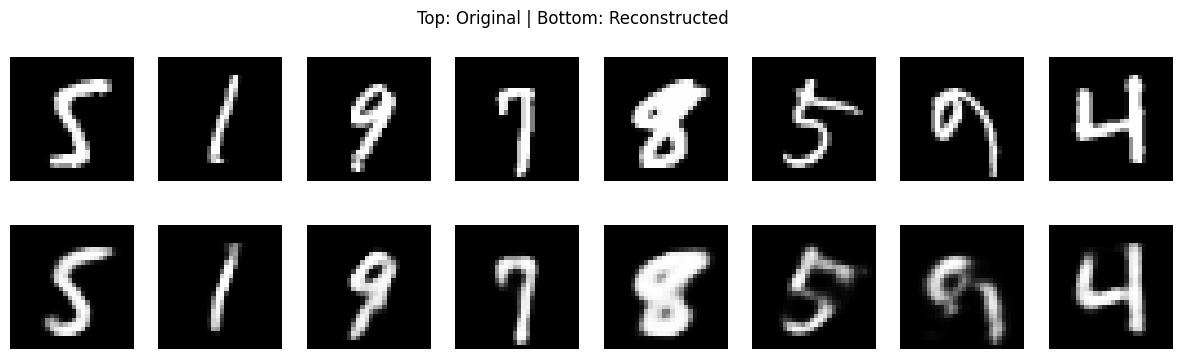

In [7]:
#6.복원 이미지 시각화
model.eval()
with torch.no_grad():
    sample = next(iter(train_loader))[0][:8].to(device)
    recon, _, _ = model(sample)

    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(sample[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()

## 🎨 Visualizing the Latent Space (2D)

**To visualize the latent space in 2D, the `latent_dim` of the VAE must be exactly 2.**

Our human eyes can only visually comprehend up to 2 or 3 dimensions. Think of it like creating a 2D map: you need two pieces of information (longitude and latitude) for every location. Similarly, to draw the VAE's learned latent space on a 2D plane, the model's latent dimension must be precisely 2.

If the `latent_dim` is greater than 2, you would need to use a separate **dimensionality reduction** technique (like PCA or t-SNE) to project the high-dimensional space down to 2D. This approach can sometimes distort the learned structure and won't be as clean as a VAE that was directly trained for 2D visualization.

Therefore, if you want to visually analyze the structure of the latent space, you should **define and train a new VAE model** with a `latent_dim=2`.

In [8]:
model = VAE(latent_dim=2).to(device)

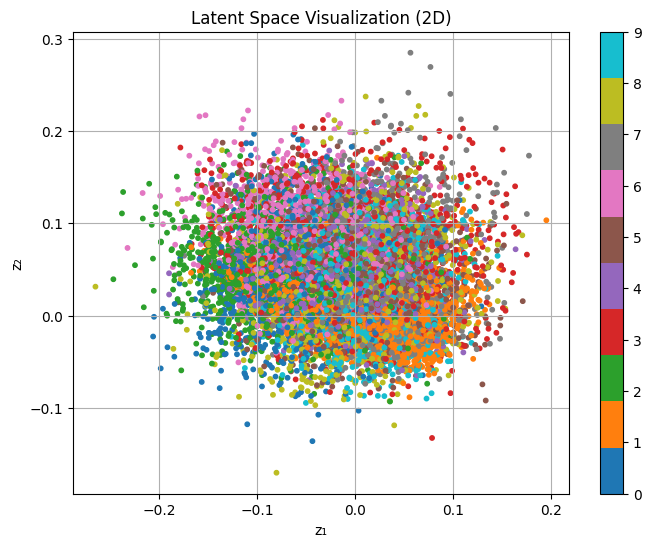

In [9]:
import numpy as np

model.eval()
z_list = []
label_list = []

with torch.no_grad():
    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        mu, _ = model.encode(data)
        z_list.append(mu.cpu())
        label_list.append(labels)
        if i == 100:  # 너무 많으면 느려지므로 일부만 사용
            break

z = torch.cat(z_list)
labels = torch.cat(label_list)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("Latent Space Visualization (2D)")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()

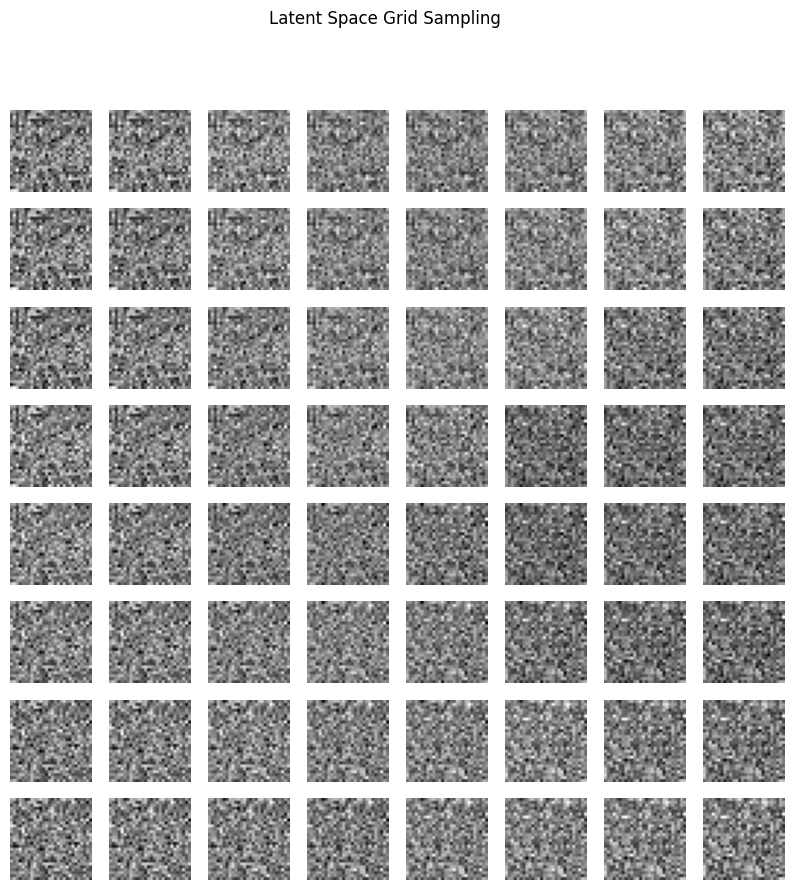

In [10]:
with torch.no_grad():
    # -2 ~ 2 범위의 격자 생성
    grid_x = torch.linspace(-2, 2, steps=8)
    grid_y = torch.linspace(-2, 2, steps=8)

    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]]).to(device)
            sample = model.decode(z)
            axes[i, j].imshow(sample.cpu().squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle("Latent Space Grid Sampling")
    plt.show()